In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from infra.model_base import ModelBase
from infra.train import Metrics, Evaluator
from infra.dataset import ClimateHackDataset
from infra.clstm import Seq2Seqv2
from tqdm import tqdm
from loss import MS_SSIMLoss
import matplotlib.pyplot as plt

In [3]:
loss_fn = torch.nn.MSELoss()
seq2seq = Seq2Seqv2(checkpoint_dir="./checkpoint/seq2seq")
optim = torch.optim.Adam(seq2seq.parameters(), lr=1e-2)
checkpoint = torch.load("./checkpoint/autoencoder/basic_autoencoder.pth")
seq2seq.gen.load_state_dict(checkpoint["generator_weight"])
seq2seq.gen.eval()
seq2seq.embedder.load_state_dict(checkpoint["embedder_weight"])
seq2seq.embedder.eval()
print("")

In [4]:
for param in seq2seq.embedder.parameters():
    param.requires_grad = False
for param in seq2seq.gen.parameters():
    param.requires_grad = False

In [5]:
training_data = ClimateHackDataset("./temp/processed", torch.device('cpu'), count=100, train_mode=True)
testing_data = ClimateHackDataset("./temp/processed", torch.device('cpu'), count=100, train_mode=False)
train_loader = torch.utils.data.DataLoader(training_data, batch_size=16)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=16)

In [8]:
losses = []
num_epochs = 10
cl_update = 1 / num_epochs
for i in range(10):
    cl_thres=0.9
    for X,y in tqdm(train_loader):
        output = seq2seq(X,y, cl_thres=cl_thres)
        loss_val = loss_fn(output, y)
        loss_val.backward()
        optim.step()
        losses.append(loss_val.detach().item())
    print(f"Epoch {i}: {losses[-1]}") 
    seq2seq.save(name=f"epoch{i}")
    cl_thres -= cl_update

100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


Epoch 0: 0.10931968688964844


100%|██████████| 7/7 [00:27<00:00,  3.93s/it]


Epoch 1: 0.07670485228300095


100%|██████████| 7/7 [00:27<00:00,  3.89s/it]


Epoch 2: 0.10383521765470505


100%|██████████| 7/7 [00:26<00:00,  3.79s/it]


Epoch 3: 0.08377841860055923


100%|██████████| 7/7 [00:26<00:00,  3.74s/it]


Epoch 4: 0.08904849737882614


100%|██████████| 7/7 [00:27<00:00,  3.97s/it]


Epoch 5: 0.07303040474653244


100%|██████████| 7/7 [00:31<00:00,  4.54s/it]


Epoch 6: 0.08898520469665527


100%|██████████| 7/7 [00:31<00:00,  4.51s/it]


Epoch 7: 0.0953596904873848


100%|██████████| 7/7 [00:30<00:00,  4.40s/it]


Epoch 8: 0.0836084708571434


100%|██████████| 7/7 [00:30<00:00,  4.40s/it]

Epoch 9: 0.06467311829328537


In [19]:
with torch.no_grad():
    for X,y in tqdm(test_loader):
        output = seq2seq(X,y)
        loss_val = loss_fn(output, y)
        print(loss_val)

 14%|█▍        | 1/7 [00:02<00:14,  2.43s/it]

tensor(0.0590)


<AxesSubplot:>

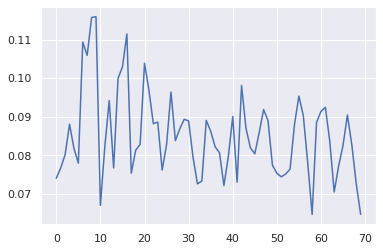

In [9]:
import seaborn as sns
sns.set_theme()
sns.lineplot(x=torch.arange(0, len(losses)), y=losses)
# sns.lineplot(x=torch.arange(0, len(val_loss)), y=val_loss)

In [3]:
testing_data = ClimateHackDataset("./temp/processed", torch.device('cpu'), count=1000, train_mode=False)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=1)
test_iter = iter(test_loader)

In [5]:
model = Seq2Seqv2(checkpoint_dir="./checkpoint/seq2seq")
checkpoint = model.load(id="epoch9")

In [6]:
for i in range(72):
    next(test_iter)

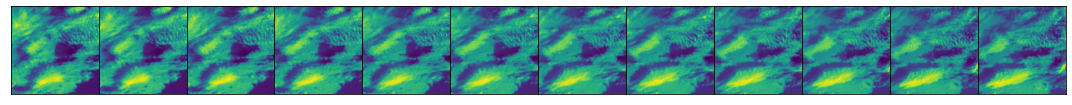

In [7]:
X,Y = next(test_iter)
fig, ax = plt.subplots(1, 12, figsize=(15,5))
for i in range(12):
    ax[i].imshow(X[0,i,:,:], cmap='viridis')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

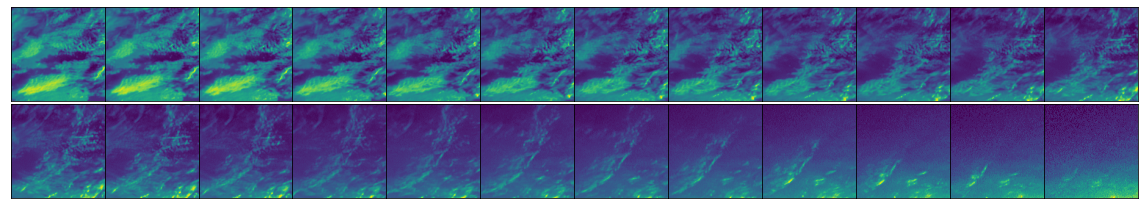

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 12, figsize=(16,3))
for i in range(12):
    ax1[i].imshow(Y[0,i,:,:], cmap='viridis')
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

for i in range(12):
    ax2[i].imshow(Y[0,12+i,:,:], cmap='viridis')
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

In [9]:
model.eval()
with torch.no_grad():
    y_pred = model(X,Y)
    pred = y_pred.cpu().detach()

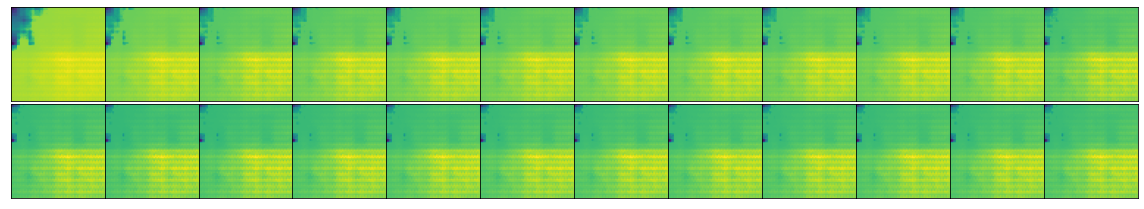

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 12, figsize=(16,3))
for i in range(12):
    ax1[i].imshow(pred[0,i,:,:], cmap='viridis')
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

for i in range(12):
    ax2[i].imshow(pred[0,12+i,:,:], cmap='viridis')
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

In [11]:
pred.min()

tensor(71.3736)

In [12]:
pred.max()

tensor(559.1378)

In [13]:
pred.size()

torch.Size([1, 24, 64, 64])